In [110]:
%matplotlib widget

import tensorflow as tf
import os
import sys
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
DATASET_PATH = "/Users/jeremy/Google Drive/datasets/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['embeddings.tsv', '.DS_Store', 'images.csv', 'images', 'styles', 'styles.csv', '.ipynb_checkpoints', 'embeddings.csv', 'resnet50-embeddings.pkl']


In [3]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [204]:
df['season'].astype(float)

ValueError: could not convert string to float: 'Fall'

In [4]:
# Load ResNet-50 model pretrained on Imagenet without the classifying layers on top.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Max Pooling layer on top
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [4]:
def get_img_path(img):
  return DATASET_PATH + "images/" + img

In [5]:
def extract_embeddings(img_name, model):
  input_shape = (224, 224, 3)
  img = image.load_img(get_img_path(img_name), target_size=(input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  embeddings = model.predict(preprocessed_img)
  return embeddings.reshape(-1)

In [6]:
emb = extract_embeddings(df.iloc[0].image, model)
emb.shape

NameError: name 'model' is not defined

In [47]:
get_img_path(df.iloc[282].image)

'/Users/jeremy/Google Drive/datasets/fashion-dataset/images/5402.jpg'

In [48]:
img_array = get_img_path(df.iloc[0].image)
plt.imshow(img_array)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [ ]:
# Create embeddings and store them into dataframe
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: extract_embeddings(img, model))
df_embs        = map_embeddings.apply(pd.Series)

In [ ]:
# Serialize dataframe to pickle file
df_embs.to_pickle(DATASET_PATH + "resnet50-embeddings.pkl")

In [6]:
df_embs = pickle.load(open(DATASET_PATH + "resnet50-embeddings.pkl", "rb"))

In [7]:
# Perform PCA over the embeddings to reduce dimensionality before applying t-sne
num_feature_dimensions = 2  # Set the number of embedding dimensions
pca = PCA(n_components = num_feature_dimensions)
embs_compressed = pca.fit_transform(df_embs)
df_embs_compressed = pd.DataFrame(embs_compressed)

In [8]:
df_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.661316,2.366165,0.000000,3.255730,0.845208,2.673841,8.780870,6.280786,0.787188,1.587657,...,2.463610,0.000000,1.825994,20.485268,3.902863,0.000000,8.225969,1.313863,0.000000,10.820526
1,5.790417,9.593648,0.000000,9.431670,0.287235,0.259945,17.028748,3.037453,0.136341,0.000000,...,1.670570,0.013891,10.338681,4.784722,0.189140,0.000000,7.739144,0.372693,0.000000,8.903802
2,0.000000,3.162254,0.484691,0.172299,2.609548,3.840852,3.426139,0.253253,1.098907,1.418282,...,0.434926,14.092834,3.018744,2.134506,2.549062,0.377385,6.180348,0.636620,14.018165,11.415048
3,5.882203,1.958606,0.000000,12.519882,0.000000,0.000000,9.383594,3.781614,0.000000,1.490617,...,17.825478,0.000000,3.592507,2.042305,0.000000,0.000000,6.656779,1.457314,1.694204,1.403327
4,0.245968,17.383430,0.493824,3.374468,2.567368,0.000000,6.482537,5.862639,0.000000,3.164866,...,4.464024,0.447075,1.448143,12.884138,0.000000,0.397501,5.028075,1.939697,0.000000,11.485400


In [159]:
df_embs_compressed

,0,1
0,-106.874687,-38.914036
1,-97.877335,-42.474579
2,24.955183,105.210495
3,-83.753189,-23.996069
4,-106.195755,-32.475075
...,...,...
4995,107.943764,-54.752693
4996,36.390488,52.702984
4997,-44.724003,7.185936
4998,121.626785,-42.053097


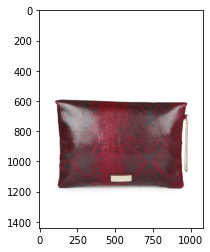

In [103]:
%matplotlib inline
img = plt.imread(get_img_path(df.iloc[3677].image))
plt.imshow(img)
plt.show()

In [104]:
# override any Null values
df.at[87, 'usage'] = "Casual"
df.at[92, 'usage'] = "Travel"
df.at[292, 'usage'] = "Casual"
df.at[479, 'usage'] = "Smart Casual"
df.at[511, 'usage'] = "Smart Casual"
df.at[559, 'usage'] = "Casual"
df.at[699, 'usage'] = "Travel"
df.at[899, 'usage'] = "Smart Casual"
df.at[900, 'usage'] = "Casual"
df.at[912, 'usage'] = "Travel"
df.at[955, 'usage'] = "Travel"
df.at[1166, 'usage'] = "Smart Casual"
df.at[1184, 'usage'] = "Formal"
df.at[1272, 'usage'] = "Travel"
df.at[1286, 'usage'] = "Casual"
df.at[1494, 'usage'] = "Formal"
df.at[1529, 'usage'] = "Casual"
df.at[1548, 'usage'] = "Travel"
df.at[1799, 'usage'] = "Ethnic"
df.at[1816, 'usage'] = "Travel"
df.at[2088, 'usage'] = "Formal"
df.at[2119, 'usage'] = "Casual"
df.at[2587, 'usage'] = "Casual"
df.at[2599, 'usage'] = "Travel"
df.at[2604, 'usage'] = "Formal"
df.at[2801, 'usage'] = "Formal"
df.at[3220, 'usage'] = "Travel"
df.at[3271, 'usage'] = "Travel"
df.at[3307, 'usage'] = "Casual"
df.at[3467, 'usage'] = "Travel"
df.at[3472, 'usage'] = "Casual"
df.at[3476, 'usage'] = "Formal"
df.at[3537, 'usage'] = "Casual"
df.at[3609, 'usage'] = "Formal"
df.at[3677, 'usage'] = "Formal"
df.at[3677, 'productDisplayName'] = "Red Clutch"
df.at[3721, 'usage'] = "Formal"
df.at[3795, 'usage'] = "Travel"
df.at[3821, 'usage'] = "Travel"
df.at[3843, 'usage'] = "Travel"
df.at[4033, 'usage'] = "Casual"
df.at[4053, 'usage'] = "Travel"
df.at[4218, 'usage'] = "Travel"
df.at[4234, 'usage'] = "Casual"
df.at[4272, 'usage'] = "Travel"
df.at[4639, 'usage'] = "Travel"
df.at[4642, 'usage'] = "Travel"
df.at[4657, 'usage'] = "Formal"
df.at[4892, 'usage'] = "Casual"


In [115]:
# Application of SVM to create the axis for a given feature
X = df_embs
y = df["season"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svm_clf = LinearSVC(C=1, max_iter=100000)
decision_boundary = svm_clf.fit(X_scaled, y)

In [181]:
dbxx, dbyy = calc_svm_decision_boundary(decision_boundary, -150, 150)

In [164]:
df['x'] = df_embs_compressed[0]
df['y'] = df_embs_compressed[1]

In [165]:
def create_user_marker(x, y):
    """Creates and returns a user marker on a specific position"""
    user_marker = plt.plot(x, y, 'yo', markersize=10)
    user_position = np.array([x, y])
    return user_marker, user_position

In [166]:
def get_updated_user_pos(change):
    """
    Computes the index of the element that is closest to the given change value in x0.
    Returns the new user position.
    """
    index = np.where(np.isclose(neg_decision_boundary, min(neg_decision_boundary, key=lambda x:abs(x-change))))
    return neg_decision_boundary[index[0][0]], x0[index[0][0]]

In [167]:
def update_user_position(change):
    """Update the user position after the slider value has changed"""
    new_x, new_y = get_updated_user_pos(change.new)
    user_marker[0].set_data(new_x, new_y)
    new_user_pos = np.array([new_x, new_y])
    nearest_neighbour, nearest_neighbour_pos = get_nearest_neighbour(new_user_pos, df)
    annotate_nearest_neighbour(nearest_neighbour, nearest_neighbour_pos, ax, df)
    plt.title('Nearest Embedding: {}'.format(nearest_neighbour))
    fig.canvas.draw()
    fig.canvas.flush_events()

In [174]:
def calc_svm_decision_boundary(svm_clf, xmin, xmax):
    """Compute a decision boundary and ret"""
    w = svm_clf.coef_[0]
    a = svm_clf.intercept_[0]
    xx = np.linspace(xmin, xmax)
    yy = -w[0]/w[1] * xx - a/w[1]
    return xx, yy

In [169]:
def get_nearest_neighbour(user_position, df):
   nearest_neighbour = None
   nearest_neighbour_pos = None
   smallest_dist = sys.maxsize
   for row in df.itertuples():
      embedding_position = np.array([row.x, row.y])
      dist = norm(user_position - embedding_position)
      if dist < smallest_dist:
         smallest_dist = dist
         nearest_neighbour = row.id
         nearest_neighbour_pos = embedding_position
   return nearest_neighbour, nearest_neighbour_pos

In [170]:
def highlight_nearest_neighbour(id, df):
    x_nn = df.loc[df['id'] == id].x.values[0]
    y_nn = df.loc[df['id'] == id].y.values[0]
    plt.scatter(x=x_nn, y=y_nn, color='r')

In [171]:
def annotate_nearest_neighbour(nearest_neighbour, nearest_neighbour_pos, ax, df):
    if ax.artists != []:
        ax.artists[0].remove()
    arr_img = plt.imread(get_img_path(df.loc[df['id'] == nearest_neighbour].image.values[0]))
    imagebox = OffsetImage(arr_img, zoom=0.025)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, nearest_neighbour_pos, xybox=(-20, 40), xycoords='data', boxcoords="offset points", arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

In [172]:
df.loc[df['id'] == 45097]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,x,y
1334,45097,Women,Apparel,Innerwear,Bra,Pink,Winter,2015,Casual,Bwitch Pink Ruby Bra,45097.jpg,-5.391746,-2.187279


In [178]:
plt.plot(dbxx, dbyy, "k-")
plt.show()

In [203]:
from ipywidgets import AppLayout, FloatSlider
from matplotlib.offsetbox import (AnnotationBbox, OffsetImage, TextArea)

plt.ioff()

fig, ax = plt.subplots(figsize=(12,7))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
sns.scatterplot(x="x", y="y",
                  hue="masterCategory", # can be replaced with `subCategory` to see more details
                  data=df,
                  legend="full",
                  alpha=0.8)


#neg_decision_boundary = np.negative(decision_boundary)

plt.plot(dbxx, dbyy, "k-", linewidth=2)
#plt.plot(neg_decision_boundary, x0, "k-", linewidth=2)

rand_idx = random.choice(range(len(dbxx)))
x = dbxx[rand_idx]
y = dbyy[rand_idx]
user_marker, user_positon = create_user_marker(x, y)

nearest_neighbour, nearest_neighbour_pos = get_nearest_neighbour(user_positon, df)
annotate_nearest_neighbour(nearest_neighbour, nearest_neighbour_pos, ax, df)

plt.title('Nearest Embedding: {}'.format(nearest_neighbour))

# Create Slider to interact with the plot
slider = FloatSlider(
    orientation="horizontal",
    description="Position:",
    value=user_positon[0],
    min=min(dbxx),
    max=max(dbxx)
)
slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

slider.observe(update_user_position, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(FloatSlider(value=101.0204081632653, description='Position:', layout=Layout(grid_area='foo…